In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from scipy.ndimage import uniform_filter
from paths import basedir, figure_path

In [12]:
# 1. SETTINGS / CASE SPECIFICATIONS
regions    = ["Pakistan", "Australia", "Scotland"]
letters = ['a)', 'b)', 'c)']
yyyy       = [2022,      2022,         2023]
mm         = [8,         2,            10]
month      = ["August", "February", "October"]    
d_start    = [10,        22,           6]
d_end      = [24,        28,           8]
d_sel      = [18,        24,           7]

# lon/lat extents (for plotting + subdomain)
minlon     = [35.0,  120.0, -50.0]
maxlon     = [100.0, 185.0, 15.0]
minlat     = [-5.0, -55.0, 20.0]
maxlat     = [45.0,   -5.0,  70.0]

# polyline box
lon_W = [67.0,  149.0, 352.0]
lon_E = [71.0,  158.0, 359.0]
lat_S = [24.0,  -32.0, 52.0]
lat_N = [30.0,  -22.0, 60.0]

# pressure levels (Pa) and physics
plev1      = 50000.0
g_const    = 9.81
smt_size   = 3        # smoothing factor

# contour levels
cn_mslp    = np.arange(990, 1030, 5)
cn_z500    = np.linspace(5520, 5910, 14)

# IVT thresholds & vector decimation
ivt_thresh1 = 200.0
ivt_thresh2 = 200.0
vec_int1    = 8
vec_int2    = 8

# colormaps
cmap_prec  = cmocean.cm.rain   #plt.get_cmap("Blues")   # vervang door je eigen colormap
cmap_gray  = (0.85, 0.85, 0.85)

# directories
synopdir = basedir + "Synoptic/"
outdir   = figure_path

os.makedirs(outdir, exist_ok=True)

In [8]:
# helper: uniform smoothing
def smooth_field(da, size):
    return xr.DataArray(
        uniform_filter(da.values, size=size, mode="nearest"),
        coords=da.coords, dims=da.dims
    )

def roll_array(arr):
    # With the code below, we roll the map, to get the 0 meridian,
    # rather than the Pacific in the middle.
    lon = arr["lon"].values
    nroll = lon.size//2
    arr = arr.roll(lon=nroll,roll_coords=True)
    arr["lon"] = xr.where(arr["lon"]>=180., arr["lon"]-360., arr["lon"])
    return arr

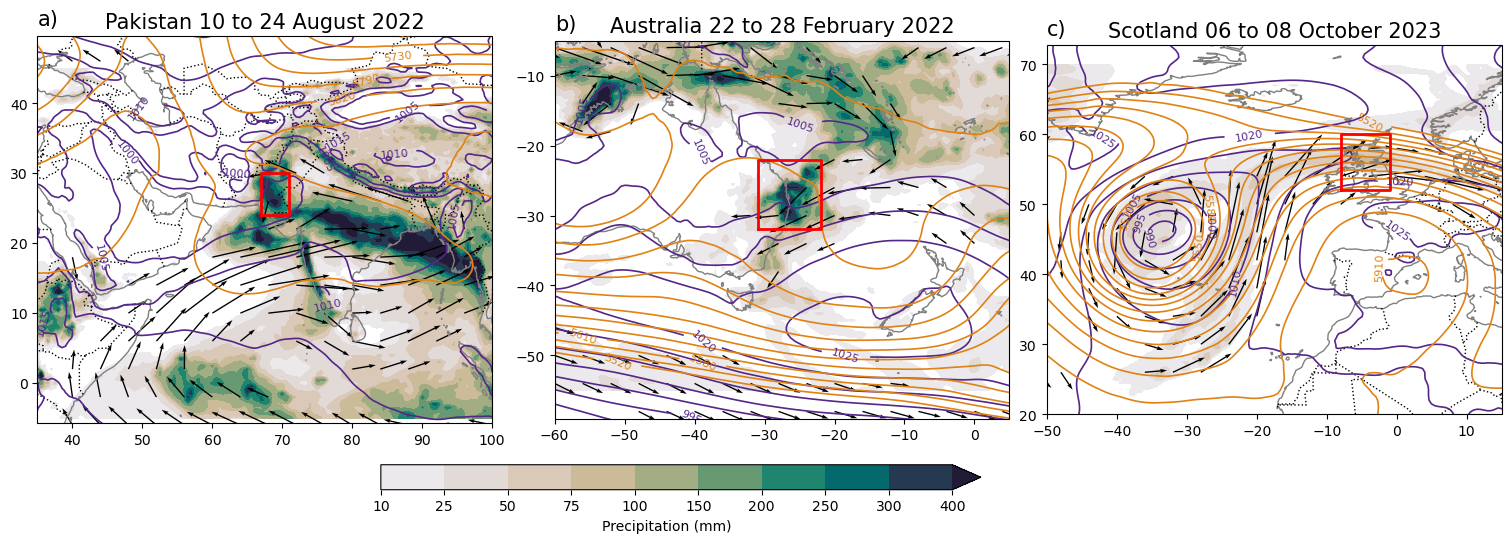

In [ ]:
# 2. LOOP OVER REGIONS, READ + PROCESS DATA
fig = plt.figure(figsize=(15, 10),constrained_layout=True)
axs= []
gs = gridspec.GridSpec(1, 3, figure=fig, height_ratios=[1])

for i, region in enumerate(regions):
    if region == "Australia":
        proj = ccrs.PlateCarree(central_longitude=180.0)
    else:
        proj = ccrs.PlateCarree()

    yy, mo = yyyy[i], mm[i]
    dslice = slice(f"{yy}-{mo:02d}-{d_start[i]:02d}",
                   f"{yy}-{mo:02d}-{d_end[i]:02d}")
    dsel   = f"{yy}-{mo:02d}-{d_sel[i]:02d}"

    # a) DAILY PRECIPITATION SUM (ERA5)
    fn_fc = f"{synopdir}era5_fc_totprec_reg05_step1to12_ds_{yy}{mo:02d}.nc"
    ds_fc = xr.open_dataset(fn_fc)
    pr = ds_fc["var228"] * 1000.0
    if region == "Scotland": 
        pr = roll_array(pr) 
    pr = pr.sel(time=dslice, lat=slice(maxlat[i], minlat[i]),
                lon=slice(minlon[i], maxlon[i]))
    pr_sum = pr.sum(dim="time")
    pr_day = pr.sel(time=dsel)

    # b) ERA5 DAILY MEAN fields: MSLP, Z500, IVT components
    fn_mslp = f"{synopdir}era5_an_mslp_reg05_dm_{yy}{mo:02d}.nc4"
    fn_geo  = f"{synopdir}era5_an_geopot_reg05_dm_{yy}{mo:02d}.nc4"
    fn_east = f"{synopdir}era5_an_ewvf_reg05_dm_{yy}{mo:02d}.nc4"
    fn_nort = f"{synopdir}era5_an_nwvf_reg05_dm_{yy}{mo:02d}.nc4"

    ds_mslp = xr.open_dataset(fn_mslp)
    ds_geo  = xr.open_dataset(fn_geo)
    ds_e    = xr.open_dataset(fn_east)
    ds_n    = xr.open_dataset(fn_nort)

    # select same time window
    mslp = ds_mslp["var151"].sel(time=dslice) / 100.0     # hPa
    z500 = ds_geo["var129"].sel(plev=plev1, time=dslice) / g_const
    ivte = ds_e["var71"].sel(time=dslice, lev=0)
    ivtn = ds_n["var72"].sel(time=dslice, lev=0)
    if region == "Scotland": 
        mslp = roll_array(mslp) 
        z500 = roll_array(z500)
        ivte = roll_array(ivte)
        ivtn = roll_array(ivtn)

    # average over days
    mslp_avg = mslp.mean(dim="time")
    z500_avg = z500.mean(dim="time")
    ile  = np.sqrt((ivte**2 + ivtn**2))
    ile_avg = np.sqrt((ivte.mean("time")**2 + ivtn.mean("time")**2))

    # smoothing
    mslp_avg_s = smooth_field(mslp_avg, smt_size)

    # 3. PLOTTING
    # subplot index: row=0 mean, row=1 day; col=i
    for row, (prec, mslp_fld, z500_fld, ivte_fld, ivtn_fld, ile_fld, ivt_t,
              vec_int) in enumerate([
        (pr_sum, mslp_avg_s, z500_avg, ivte.mean("time"), ivtn.mean("time"),
         ile_avg, ivt_thresh1, vec_int1),
    ]):
        #ax = fig.add_subplot(1, 3, row*3 + i + 1, projection=proj)
        ax = fig.add_subplot(gs[0, i], projection=proj)
        ax.set_extent([minlon[i], maxlon[i], minlat[i], maxlat[i]])
        ax.coastlines(resolution="50m", color="grey")
        ax.add_feature(cfeature.BORDERS, linestyle=":")
           
        # precipitation contourf
        levels_pr = [10,25,50,75,100,150,200,250,300,400]
        pcm = ax.contourf(
            prec.lon, prec.lat, prec.squeeze(),
            levels=levels_pr, cmap=cmap_prec,
            transform=ccrs.PlateCarree(), extend="max"
        )

        # MSLP contour
        cs1 = ax.contour(
            mslp_fld.lon, mslp_fld.lat, mslp_fld.squeeze(),
            levels=cn_mslp, colors="#542788", linewidths=1.2,
            transform=ccrs.PlateCarree()
        )

        # Z500 contour
        cs2 = ax.contour(
            z500_fld.lon, z500_fld.lat, z500_fld.squeeze(),
            levels=cn_z500, colors="#E08214", linewidths=1.2,
            transform=ccrs.PlateCarree()
        )

        # Add labels to the contours
        ax.clabel(cs1, inline=True, fontsize=8)
        ax.clabel(cs2, inline=True, fontsize=8)

        # IVT vectors (mask small)
        mask = ile_fld >= ivt_t
        lon2 = ivte_fld.lon[::vec_int]
        lat2 = ivte_fld.lat[::vec_int]
        U = ivte_fld.where(mask).sel(lon=lon2, lat=lat2).squeeze()
        V = ivtn_fld.where(mask).sel(lon=lon2, lat=lat2).squeeze()
        if(region == "Australia"):
            U = roll_array(U) #Necessary since code below gives error with proper projection
            V = roll_array(V)

        Q  = ax.quiver(
            lon2, lat2, U, V, 
            #transform=ccrs.PlateCarree(),
            scale=5000, width=0.003, color="k"
        )

        qk = ax.quiverkey(Q, 1.05, 0.95, 2, "Test", labelpos='E',
                   coordinates='figure') #r'$2 \frac{m}{s}$'
        
        # polyline
        ax.plot(
            [lon_W[i], lon_E[i], lon_E[i], lon_W[i], lon_W[i]],
            [lat_S[i], lat_S[i], lat_N[i], lat_N[i], lat_S[i]],
            transform=ccrs.PlateCarree(), color="red", linewidth=2.0
        )
        
        # titles
        title_text = f"{region} " + (
            f"{d_start[i]:02d} to {d_end[i]:02d} {month[i]} {yy}"
        )
        ax.set_title(title_text, fontsize=15)
        ax.set_xticks(ax.get_xticks()) #Why is this needed?
        ax.set_yticks(ax.get_yticks())
        ax.set_extent([minlon[i], maxlon[i], minlat[i], maxlat[i]])
        plt.text(0, 1.07, f'{letters[i]}', transform=ax.transAxes, va='top', ha='left', fontsize=15)
        axs+=[ax]
        
#fig.colorbar(pcm, ax=axs, orientation="horizontal",pad=0.01,
#                     label="Precipitation (mm)",shrink=0.25) #, aspect=50)

# Plotting the colorbar like above does not properly align the subplots
# Instead, create a new axis for the colorbar below the subplots
cbar_ax = fig.add_axes([0.3, 0.24, 0.4, 0.025])  # [left, bottom, width, height] in figure fraction
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="Precipitation (mm)")

fig.savefig(f"{figure_path}Figure2_synoptic_plot.png",
            bbox_inches="tight", dpi=300, facecolor="white")

In [ ]:
# Remove the colorbar line using ax=axs
# Instead, create a new axis for the colorbar below the subplots

cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.025])  # [left, bottom, width, height] in figure fraction
fig.colorbar(pcm, cax=cbar_ax, orientation="horizontal", label="Precipitation (mm)")


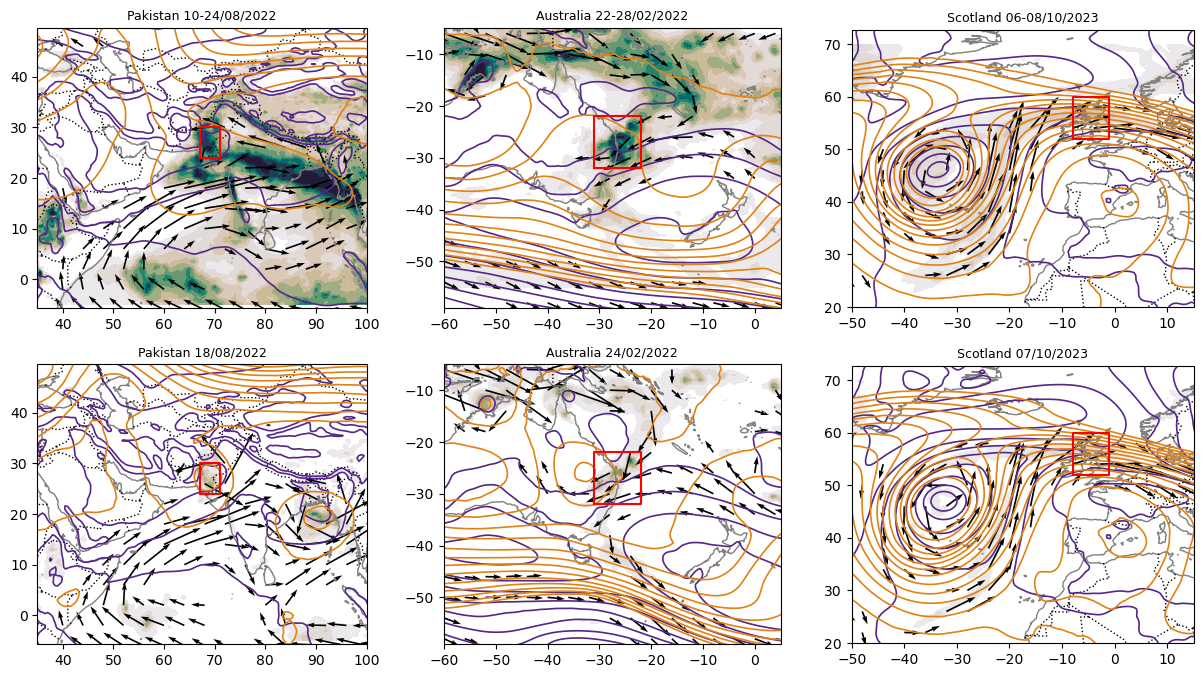

In [ ]:
# Alternative figure with also data of the single day
# 2. LOOP OVER REGIONS, READ + PROCESS DATA
fig = plt.figure(figsize=(15, 8))

for i, region in enumerate(regions):
    if region == "Australia":
        proj = ccrs.PlateCarree(central_longitude=180.0)
    else:
        proj = ccrs.PlateCarree()

    yy, mo = yyyy[i], mm[i]
    dslice = slice(f"{yy}-{mo:02d}-{d_start[i]:02d}",
                   f"{yy}-{mo:02d}-{d_end[i]:02d}")
    dsel   = f"{yy}-{mo:02d}-{d_sel[i]:02d}"

    # a) DAILY PRECIPITATION SUM (ERA5)
    fn_fc = f"{synopdir}era5_fc_totprec_reg05_step1to12_ds_{yy}{mo:02d}.nc"
    ds_fc = xr.open_dataset(fn_fc)
    pr = ds_fc["var228"] * 1000.0
    if region == "Scotland": 
        pr = roll_array(pr) 
    pr = pr.sel(time=dslice, lat=slice(maxlat[i], minlat[i]),
                lon=slice(minlon[i], maxlon[i]))
    pr_sum = pr.sum(dim="time")
    pr_day = pr.sel(time=dsel)

    # b) ERA5 DAILY MEAN fields: MSLP, Z500, IVT components
    fn_mslp = f"{synopdir}era5_an_mslp_reg05_dm_{yy}{mo:02d}.nc4"
    fn_geo  = f"{synopdir}era5_an_geopot_reg05_dm_{yy}{mo:02d}.nc4"
    fn_east = f"{synopdir}era5_an_ewvf_reg05_dm_{yy}{mo:02d}.nc4"
    fn_nort = f"{synopdir}era5_an_nwvf_reg05_dm_{yy}{mo:02d}.nc4"

    ds_mslp = xr.open_dataset(fn_mslp)
    ds_geo  = xr.open_dataset(fn_geo)
    ds_e    = xr.open_dataset(fn_east)
    ds_n    = xr.open_dataset(fn_nort)

    # select same time window
    mslp = ds_mslp["var151"].sel(time=dslice) / 100.0     # hPa
    z500 = ds_geo["var129"].sel(plev=plev1, time=dslice) / g_const
    ivte = ds_e["var71"].sel(time=dslice, lev=0)
    ivtn = ds_n["var72"].sel(time=dslice, lev=0)
    if region == "Scotland": 
        mslp = roll_array(mslp) 
        z500 = roll_array(z500)
        ivte = roll_array(ivte)
        ivtn = roll_array(ivtn)

    # average over days
    mslp_avg = mslp.mean(dim="time")
    z500_avg = z500.mean(dim="time")
    ile  = np.sqrt((ivte**2 + ivtn**2))
    ile_avg = np.sqrt((ivte.mean("time")**2 + ivtn.mean("time")**2))

    # select single-day fields
    mslp_day = mslp.sel(time=dsel)
    z500_day = z500.sel(time=dsel)
    ivte_day = ivte.sel(time=dsel)
    ivtn_day = ivtn.sel(time=dsel)
    ile_day = np.sqrt(ivte_day**2 + ivtn_day**2)

    # smoothing
    mslp_avg_s = smooth_field(mslp_avg, smt_size)
    mslp_day_s = smooth_field(mslp_day, smt_size)

    # 3. PLOTTING
    # subplot index: row=0 mean, row=1 day; col=i
    for row, (prec, mslp_fld, z500_fld, ivte_fld, ivtn_fld, ile_fld, ivt_t,
              vec_int) in enumerate([
        (pr_sum, mslp_avg_s, z500_avg, ivte.mean("time"), ivtn.mean("time"),
         ile_avg, ivt_thresh1, vec_int1),
        (pr_day, mslp_day_s, z500_day, ivte_day, ivtn_day,
         ile_day, ivt_thresh2, vec_int2),
    ]):
        ax = fig.add_subplot(2, 3, row*3 + i + 1, projection=proj)
        ax.set_extent([minlon[i], maxlon[i], minlat[i], maxlat[i]])
        ax.coastlines(resolution="50m", color="grey")
        ax.add_feature(cfeature.BORDERS, linestyle=":")
           
        # precipitation contourf
        levels_pr = [10,25,50,75,100,150,200,250,300,400]
        pcm = ax.contourf(
            prec.lon, prec.lat, prec.squeeze(),
            levels=levels_pr, cmap=cmap_prec,
            transform=ccrs.PlateCarree(), extend="max"
        )

        # MSLP contour
        cs1 = ax.contour(
            mslp_fld.lon, mslp_fld.lat, mslp_fld.squeeze(),
            levels=cn_mslp, colors="#542788", linewidths=1.2,
            transform=ccrs.PlateCarree()
        )

        # Z500 contour
        cs2 = ax.contour(
            z500_fld.lon, z500_fld.lat, z500_fld.squeeze(),
            levels=cn_z500, colors="#E08214", linewidths=1.2,
            transform=ccrs.PlateCarree()
        )

        # IVT vectors (mask small)
        mask = ile_fld >= ivt_t
        lon2 = ivte_fld.lon[::vec_int]
        lat2 = ivte_fld.lat[::vec_int]
        U = ivte_fld.where(mask).sel(lon=lon2, lat=lat2).squeeze()
        V = ivtn_fld.where(mask).sel(lon=lon2, lat=lat2).squeeze()
        if(region == "Australia"):
            U = roll_array(U)
            V = roll_array(V)

        ax.quiver(
            lon2, lat2, U, V, 
            #transform=ccrs.PlateCarree(),
            scale=5000, width=0.005, color="k"
        )
        
        # polyline
        ax.plot(
            [lon_W[i], lon_E[i], lon_E[i], lon_W[i], lon_W[i]],
            [lat_S[i], lat_S[i], lat_N[i], lat_N[i], lat_S[i]],
            transform=ccrs.PlateCarree(), color="red", linewidth=1.5
        )
        
        # titles
        title_text = f"{region} " + (
            f"{d_start[i]:02d}-{d_end[i]:02d}/{mo:02d}/{yy}"
            if row == 0 else
            f"{d_sel[i]:02d}/{mo:02d}/{yy}"
        )
        ax.set_title(title_text, fontsize=9)
        ax.set_xticks(ax.get_xticks()) #Why is this needed?
        ax.set_yticks(ax.get_yticks())
        ax.set_extent([minlon[i], maxlon[i], minlat[i], maxlat[i]])

fig.savefig(f"{figure_path}Figure2_synoptic_plot_full.png",
            bbox_inches="tight", dpi=300, facecolor="white")